# Preparation

We first install the KID-PPG package and matplotlib which are required for this demo.

In [ ]:
!git clone https://github.com/esl-epfl/KID-PPG

In [ ]:
! pip install ./KID_PPG

In [ ]:
! pip install -U matplotlib

# Data Preparation

KID-PPG provides demo data to get started with extracting HR from PPG signals. The demo data are part of the PPGDalia dataset.

In [ ]:
from kid_ppg.demo import demo_utils

X, y = demo_utils.load_demo_data()

The demo data are the Stairs Exercise from subject S6 of the PPGDalia dataset. In this case, the PPG is affected by motion artifacts which are linearly coupled with the PPG signal. Let's visualize the PPG and the acceleration accross the x, y and z axes in the time-frequency domain.

Text(0.5, 0.98, 'PPGDalia - S6 - Stairs Activity')

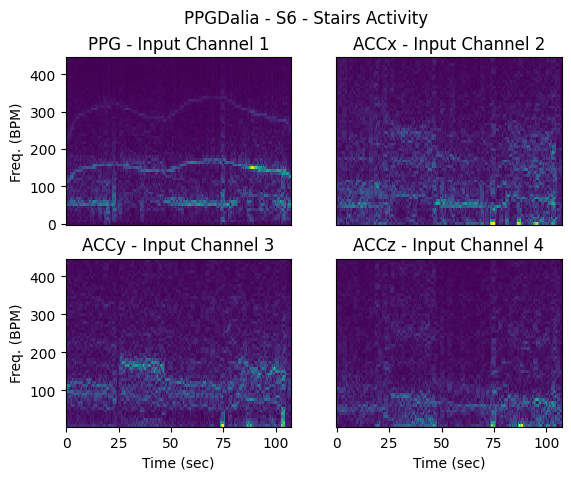

In [ ]:
import matplotlib.pyplot as plt
import scipy
import numpy as np

Y = scipy.fft.fft(X, axis = -1)
Y = np.abs(Y)[..., :128]

t = np.arange(Y.shape[0]) / 2
xf = scipy.fft.fftfreq(256, 1/32)[:128] * 60

plt.figure()

plt.subplot(2, 2, 1)
plt.pcolormesh(t, xf[:60], Y[:, 0, :60].T)
plt.ylabel('Freq. (BPM)')
plt.title('PPG - Input Channel 1')
plt.xticks([])

plt.subplot(2, 2, 2)
plt.pcolormesh(t, xf[1:60], Y[:, 1, 1:60].T)
plt.title('ACCx - Input Channel 2')
plt.xticks([])
plt.yticks([])

plt.subplot(2, 2, 3)
plt.pcolormesh(t, xf[1:60], Y[:, 2, 1:60].T)
plt.ylabel('Freq. (BPM)')
plt.title('ACCy - Input Channel 3')
plt.xlabel('Time (sec)')

plt.subplot(2, 2, 4)
plt.pcolormesh(t, xf[1:60], Y[:, 3, 1:60].T)
plt.yticks([])
plt.title('ACCz - Input Channel 4')
plt.xlabel('Time (sec)')

plt.suptitle('PPGDalia - S6 - Stairs Activity')


# Adaptive Filtering

Since there is Motion Artifact interference, we remove it using the acceleration signals as a reference. KID-PPG provides `AdaptiveFilteringModel` for linearly decoupling Blood Volume Pressure and motion information present in the PPG signal.

In [ ]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import tensorflow as tf
from kid_ppg.preprocessing import sample_wise_z_score_normalization, sample_wise_z_score_denormalization
from kid_ppg.adaptive_linear_model import AdaptiveFilteringModel

n_epochs = 1000

cur_activity_X, ms, stds = sample_wise_z_score_normalization(X.copy())

sgd = tf.keras.optimizers.legacy.SGD(learning_rate = 1e-7,
                                            momentum = 1e-2,)
model = AdaptiveFilteringModel(local_optimizer = sgd,
                                num_epochs_self_train = n_epochs)


X_filtered = model(cur_activity_X[..., None]).numpy()

X_filtered = X_filtered[:, None, :]
X_filtered = sample_wise_z_score_denormalization(X_filtered, ms, stds)

X_filtered = X_filtered[:, 0, :]

Let's now visualize the filtered PPG vs the original.

Text(0.5, 0.98, 'PPGDalia - S6 - Stairs Activity')

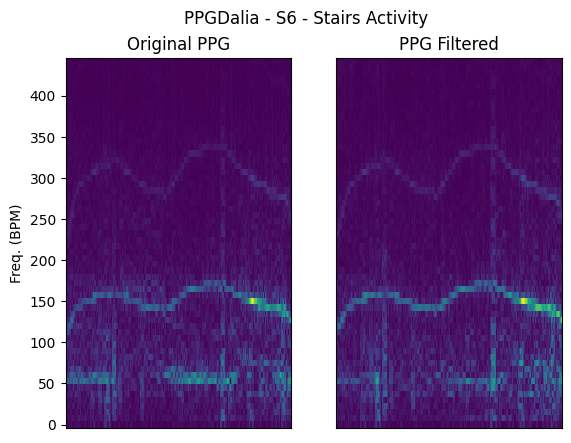

In [ ]:
Y_filtered = scipy.fft.fft(X_filtered, axis = -1)
Y_filtered = np.abs(Y_filtered)[..., :128]

t = np.arange(Y.shape[0]) / 2
xf = scipy.fft.fftfreq(256, 1/32)[:128] * 60

plt.figure()

plt.subplot(1, 2, 1)
plt.pcolormesh(t, xf[:60], Y[:, 0, :60].T)
plt.ylabel('Freq. (BPM)')
plt.title('Original PPG')
plt.xticks([])

plt.subplot(1, 2, 2)
plt.pcolormesh(t, xf[:60], Y_filtered[:, :60].T)
plt.title('PPG Filtered')
plt.xticks([])
plt.yticks([])

plt.suptitle('PPGDalia - S6 - Stairs Activity')

# Probabilistic Heart Rate Extraction

Now that we have acquired a filtered version of the PPG we can run the KID-PPG model to extract the heart rate. Since KID-PPG estimates a heart rate distribution the model returns the expected value and the standard deviation. The heart rate distribution allows for soft labeling the model's certainty on its estimates. However, in a lot of applications, it is useful to have a yes/no answer on whether to retain the sample or not. KID-PPG provides this capability through the error classifier.

The `predict()` function returns the expected HR, the standard deviation and the error classifier probability. In this example we choose a threshold of 10BPM.

In [ ]:
from kid_ppg.kid_ppg import KID_PPG
from kid_ppg.preprocessing import create_temporal_pairs
from src.kid_ppg.hdcppg import KID_PPG_HDC #new 

# X_filtered_temp, y_temp = create_temporal_pairs(X_filtered, y)
# kid_ppg_model = KID_PPG()

input_shape = X_filtered.shape 
ppg_model = KID_PPG_HDC(input_shape=input_shape) # X_filtered & y 

In [ ]:
# Train the model
ppg_model.train(X_filtered, y)

In [ ]:
predictions, actuals = ppg_model.test(X_filtered, y)

In [ ]:
predictions[:10]

In [ ]:
actuals[:10]

In [ ]:
patient_id = list(range(1, len(predictions)+1))

x = patient_id
y1 = predictions
y2 = actuals


# plot line
plt.plot(x,y1)
plt.plot(x,y2)
plt.show()
